# Supervised graph classification example

This notebook demonstrates how to train a graph classification model in a supervised setting using graph convolutional layers followed by a mean pooling layer as well as any number of fully connected layers.

The graph convolutional classification model architecture is based on the one proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2]. This demo differs from [1] in the dataset, MUTAG, used here; MUTAG is a collection of static graphs representing chemical compounds with each graph associated with a binary label. Furthermore, none of the graph convolutional layers in our model utilise an attention head as proposed in [1].

Evaluation data for graph kernel-based approaches shown in the very last cell in this notebook are taken from [3].

**References**

[1] Fake News Detection on Social Media using Geometric Deep Learning, F. Monti, F. Frasca, D. Eynard, D. Mannion, and M. M. Bronstein, ICLR 2019. ([link](https://arxiv.org/abs/1902.06673))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))

[3] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/supervised-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/supervised-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc2

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc2")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc2, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

## Import the data

In [4]:
dataset = datasets.MUTAG()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [5]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class. Note that `graphs` is a list of `StellarGraph` graph objects.

In [6]:
generator = PaddedGraphGenerator(graphs=graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `GraphClassification` class together with standard `tf.Keras` layers, e.g., `Dense`. 

The input is the graph represented by its adjacency and node features matrices. The first two layers are Graph Convolutional as in [2] with each layer having 64 units and `relu` activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 32 and 16 units respectively and `relu` activations. The last layer is the output layer with a single unit and `sigmoid` activation.

![](graph_classification_architecture.png)

In [7]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

### Train the model

We can now train the model using the model's `fit` method. First, we specify some important training parameters such as the number of training epochs, number of fold for cross validation and the number of time to repeat cross validation.

In [8]:
epochs = 200  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [9]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

The method `train_fold` is used to traing a graph classification model for a single fold of the data.

In [10]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [11]:
def get_generators(train_index, targets, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

The code below puts all the above functionality together in a training loop for repeated k-fold cross-validation where the number of folds is 10, `folds=10`; that is we do 10-fold cross validation `n_repeats` times where `n_repeats=5`.

**Note**: The below code may take a long time to run depending on the value set for `n_repeats`. The larger the latter, the longer it takes since for each repeat we train and evaluate 10 graph classification models, one for each fold of the data. For progess updates, we recommend that you set `verbose=2` in the call to the `fit` method is cell 10, line 3.

In [12]:
test_accs = []

for train_index, test_index in model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels):

    train_gen, test_gen = get_generators(train_index, test_index, batch_size=30)

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']
  ['...']


In [13]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 75.4% and std: 7.8%


Finally, we plot a histogram of the accuracy of all `n_repeats x folds` models trained (50 in total).

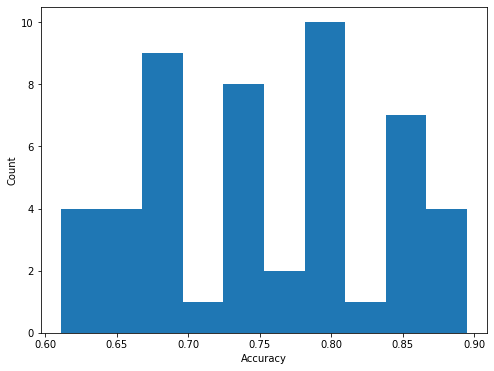

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

The histogram shown above indicates the difficulty of training a good model on the MUTAG dataset due to the following factors,
- small amount of available data, i.e., only 188 graphs
- small amount of validation data since for a single fold only 19 graphs are used for validation
- the data are unbalanced since the majority class is twice as prelevant in the data

Given the above, average performance as estimated using repeated 10-fold cross validation displays high variance but overall good performance for a straightforward application of graph convolutional neural networks to supervised graph classification. The high variance is likely the result of the small dataset size.

Generally, performance is a bit lower than SOTA in recent literature. However, we have not tuned the model for the best performance possible so some improvement over the current baseline may be attainable.

When comparing to graph kernel-based approaches, our straightforward GCN with mean pooling graph classification model is competitive with the WL kernel being the exception.

For comparison, some performance numbers repeated from [3] for graph kernel-based approaches are, 
- Graphlet Kernel (GK): $81.39\pm1.74$
- Random Walk Kernel (RW): $79.17\pm2.07$
- Propagation Kernel (PK): $76.00\pm2.69$
- Weisfeiler-Lehman Subtree Kernel (WL): $84.11\pm1.91$

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/supervised-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/supervised-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>